In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns 

### Load the data

In [2]:
dataset = pd.read_csv('./Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset.csv')
dataset.head(4)

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientid          1000 non-null   int64  
 1   age                1000 non-null   int64  
 2   gender             1000 non-null   int64  
 3   chestpain          1000 non-null   int64  
 4   restingBP          1000 non-null   int64  
 5   serumcholestrol    1000 non-null   int64  
 6   fastingbloodsugar  1000 non-null   int64  
 7   restingrelectro    1000 non-null   int64  
 8   maxheartrate       1000 non-null   int64  
 9   exerciseangia      1000 non-null   int64  
 10  oldpeak            1000 non-null   float64
 11  slope              1000 non-null   int64  
 12  noofmajorvessels   1000 non-null   int64  
 13  target             1000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 109.5 KB


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

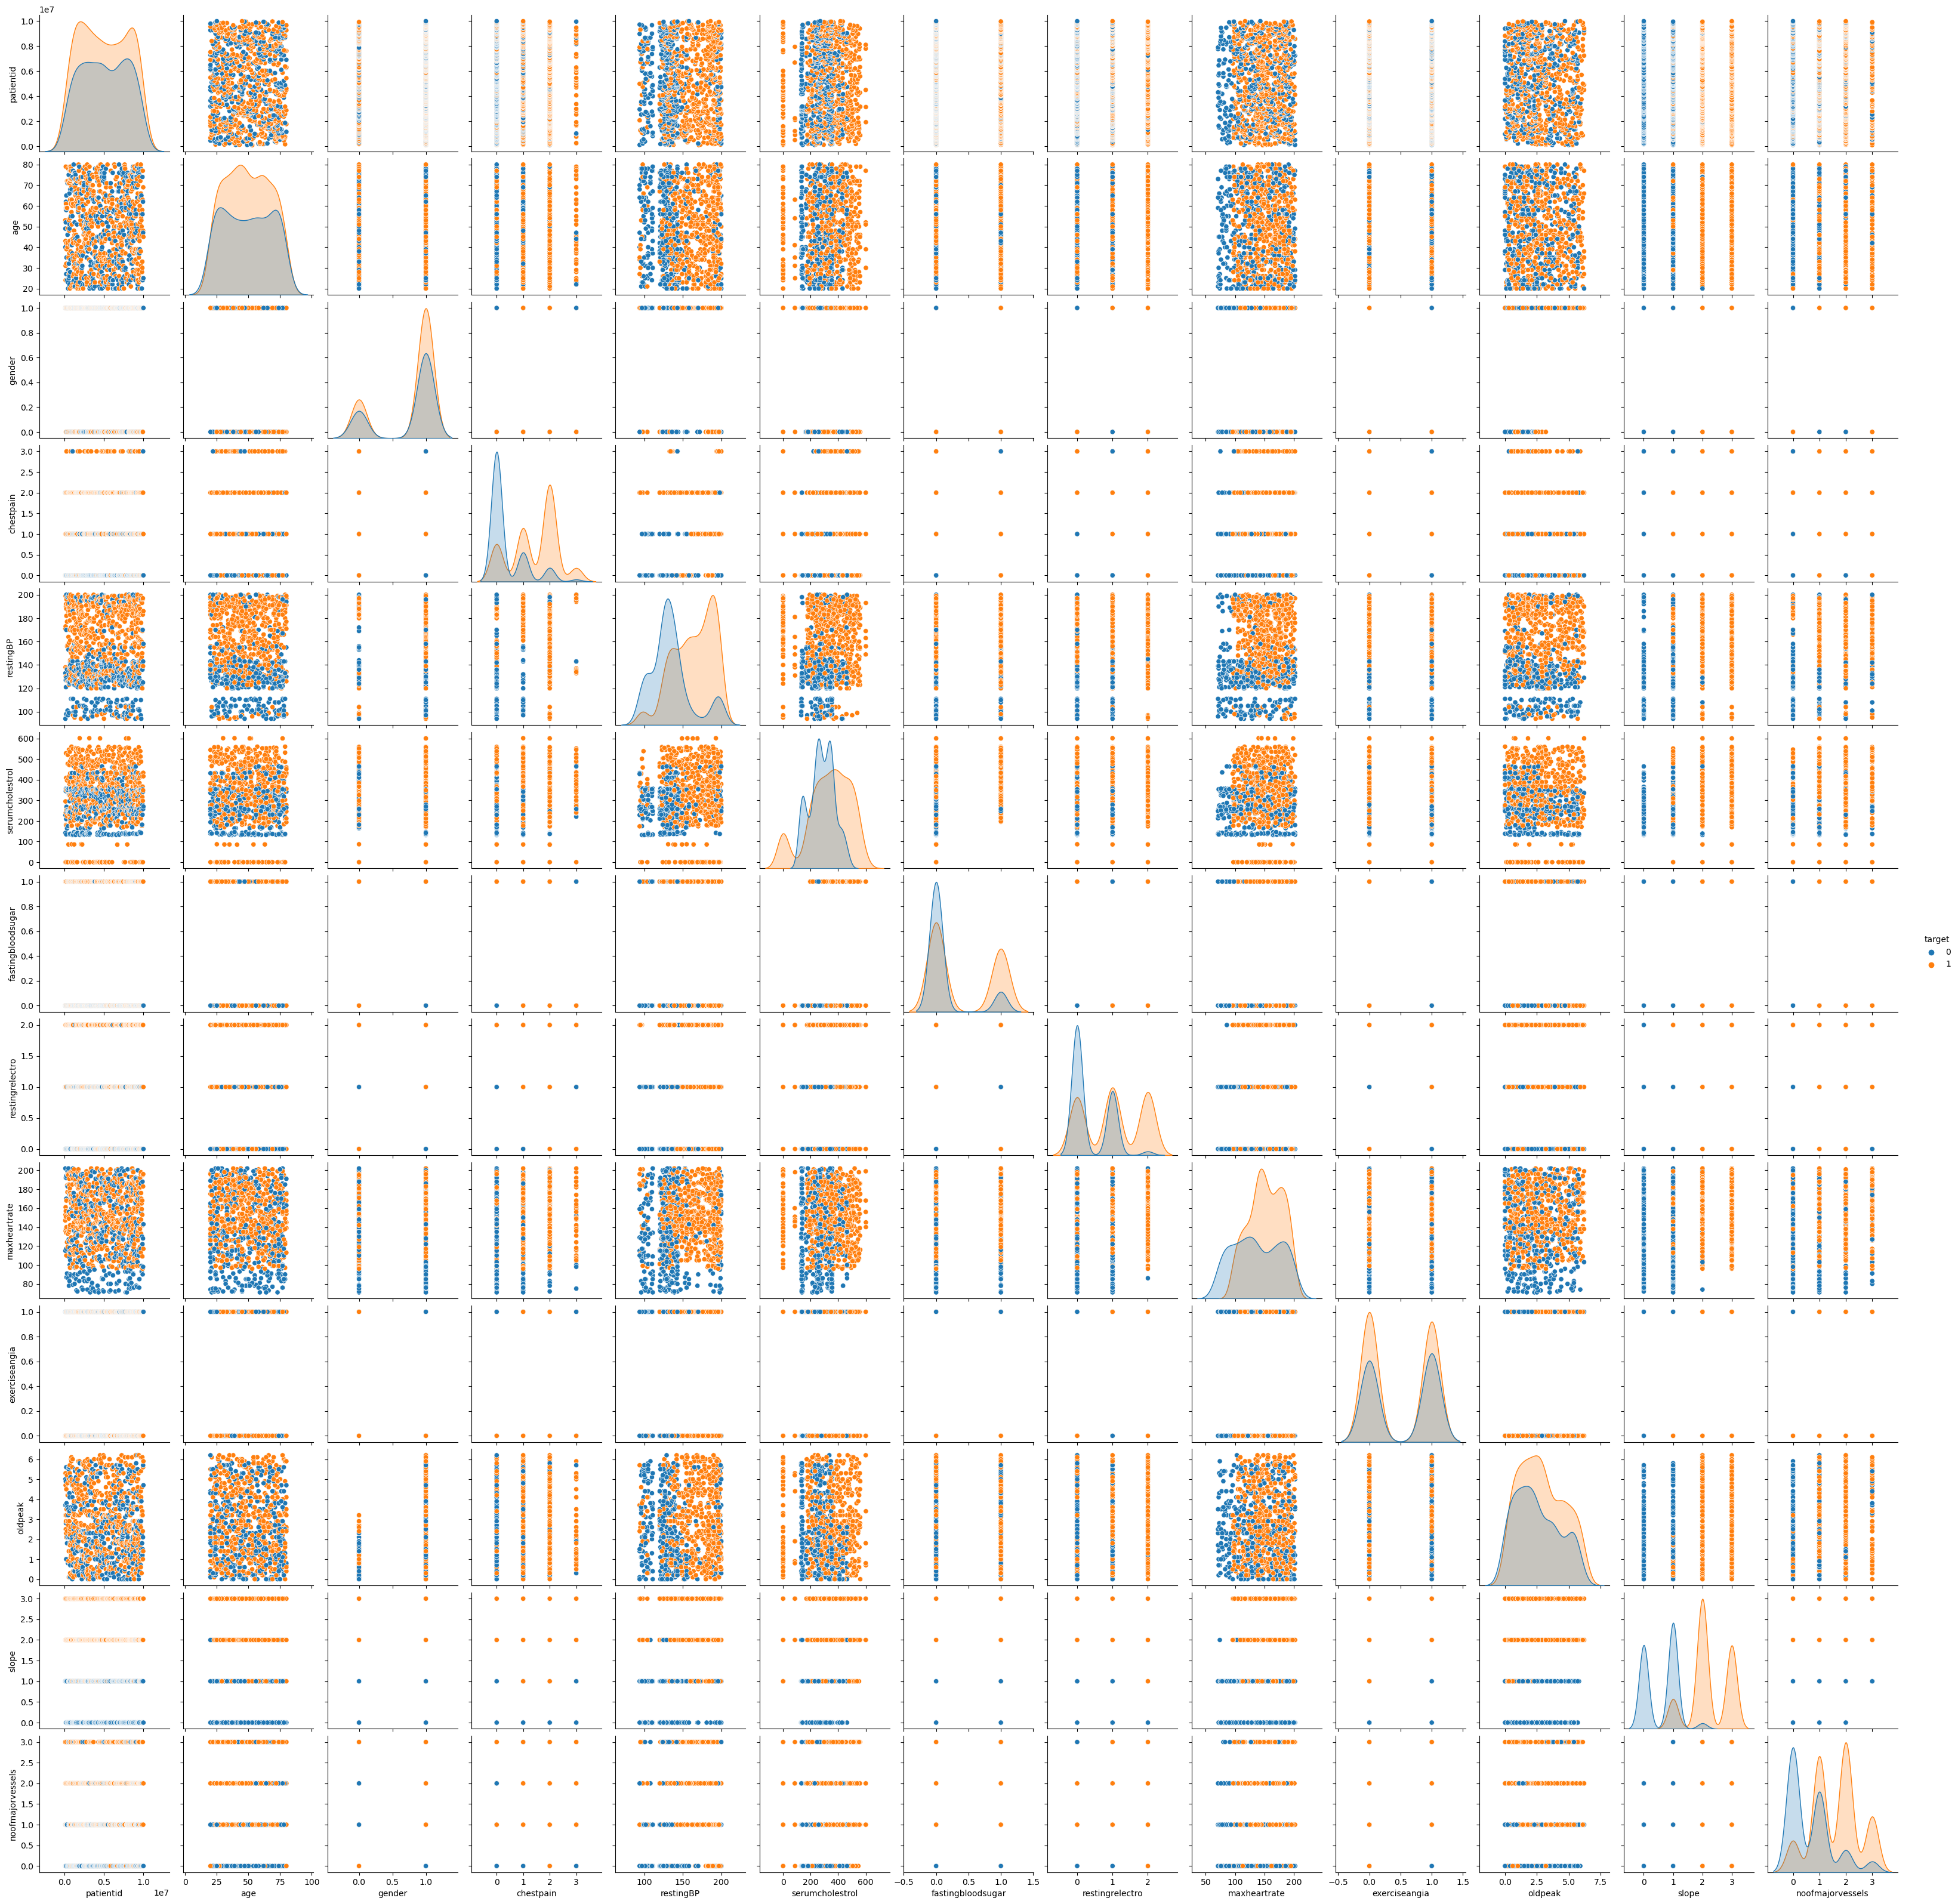

In [4]:
sns.pairplot(dataset, hue='target')

### Local Training

In [11]:
def train_local_model(X_Client, Y_Client, test_size=0.2,random_state=42, max_iter = 100):
    # Split the data locally for the train and validation
    X_train, X_test, y_train, y_test = train_test_split(X_Client,Y_Client, test_size=test_size, random_state=random_state)
    # local model
    client_model = LogisticRegression(max_iter=max_iter)

    client_model.fit(X_train,y_train)

    y_hat = client_model.predict(X_test)

    acc_client = accuracy_score(y_hat, y_test)

    # Model weights and bias
    weight_client = client_model.coef_
    bias_client = client_model.intercept_

    parameters = {
        'W': weight_client,
        'b': bias_client
    }


    return parameters, acc_client

In [76]:
# Client 1

X_1 = dataset.iloc[:800,:].drop(columns=['target','patientid'],axis=0)
Y_1 = dataset['target'].iloc[:800]
Client1_params, client1_acc = train_local_model(X_1, Y_1, max_iter=1000)
print("Client 1 parameters are : \n",Client1_params)
print("The Accuracy of Client 1 is : ", client1_acc)

Client 1 parameters are : 
 {'W': array([[-2.74764098e-03,  1.86101575e+00,  9.83509097e-01,
         3.25415341e-02,  8.00340158e-04,  4.12225791e-01,
         9.31155867e-01,  5.54512008e-03,  1.37257627e-03,
        -6.58287523e-01,  4.37352124e+00,  2.02292238e-01]]), 'b': array([-13.04682564])}
The Accuracy of Client 1 is :  0.9625


In [78]:
# Client 2 

X_2 = dataset.iloc[200:,:].drop(columns=['target','patientid'],axis=0)
Y_2 = dataset['target'].iloc[200:]
Client2_params, client2_acc = train_local_model(X_2, Y_2, max_iter=1200,random_state=30)
print("Client 1 parameters are : \n",Client2_params)
print("The Accuracy of Client 1 is : ", client2_acc)

Client 1 parameters are : 
 {'W': array([[-4.54402126e-03,  1.61450061e+00,  1.10322931e+00,
         2.98315213e-02,  1.52328509e-04,  1.19073736e+00,
         1.01127456e+00,  1.91225671e-02, -3.49537605e-01,
        -5.53068238e-01,  4.60008132e+00,  1.53453955e-01]]), 'b': array([-14.61789244])}
The Accuracy of Client 1 is :  0.95


## Global Aggregation

In [79]:
def global_aggregate_model(parameters1, parameters2):

    # we're using Federated Averaging
    # This is nA + nB where nA = 500 and nB = 500, as we have splitted the dataset equally
    nA, nB = 800, 800
    N = nA + nB

    W1 = parameters1['W'].T
    W2 = parameters2['W'].T

    Avg_W = ( nA*W1 + nB*W2 )/ N

    # Same calculation for the bias

    b1 = parameters1['b']
    b2 = parameters2['b']

    Avg_b = ( nA*b1 + nB*b2 ) / N

    return Avg_W, Avg_b
    

In [80]:
W_Server , B_server = global_aggregate_model(Client1_params, Client2_params)
print("After Federated Aggregation : ")
print("The weights are : ",W_Server.T)
print("The Bias is : ", B_server)

After Federated Aggregation : 
The weights are :  [[-3.64583112e-03  1.73775818e+00  1.04336920e+00  3.11865277e-02
   4.76334334e-04  8.01481577e-01  9.71215211e-01  1.23338436e-02
  -1.74082514e-01 -6.05677881e-01  4.48680128e+00  1.77873096e-01]]
The Bias is :  [-13.83235904]


In [81]:
def server_model(W, B, X, Y):
    
    Z = np.dot(W.T,X.T) + B

    A = 1 / (1+np.exp(-Z))

    m = X.shape[0]
    Y_predict = np.zeros((1,m))

    
    for i in range(A.shape[1]):
        
        if A[0,i] >= 0.5:
            Y_predict[0,i] = 1
        else:
            Y_predict[0,i] = 0
        
    return Y_predict


In [83]:
X = dataset.drop(columns=['target','patientid'],axis=0)
Y = dataset['target']
A = server_model(W_Server,B_server,X,Y)
A = A.T
A.shape
print("The report after Federated Aggregation: ")
print(accuracy_score(A,Y))
print(classification_report(A,Y))
print(confusion_matrix(A,Y))

The report after Federated Aggregation: 
0.967
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       421
         1.0       0.97      0.97      0.97       579

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

[[404  17]
 [ 16 563]]
